# Embeddings Notebook

This notebook focuses on the generation and analysis of vector embeddings for quantum circuits and text descriptions.

## Purpose
The primary goal of this notebook is to demonstrate how the system converts natural language text and code into high-dimensional vector representations. Specifically, it covers:

1.  **Embedding Generation**: Using the configured embedding model to transform text queries and Cirq code snippets into vector embeddings.
2.  **Dimensionality Analysis**: Verifying the output dimensions of the embeddings to ensure compatibility with the vector store.
3.  **Similarity Analysis**: Calculating cosine similarity between different embeddings to understand how the model perceives relationships between concepts.
4.  **Visualization**: Using dimensionality reduction techniques to visualize the embedding space.

## Usage
Run the cells to load the embedding model, generate embeddings for sample texts, and visualize the results.


In [1]:
# Setup and Imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path("..").resolve()
sys.path.insert(0, str(project_root))

# Import config from root config folder
from config import get_config, get_config_loader

# Import other modules
from src.rag.embeddings import EmbeddingModel, create_embedding_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("✅ Imports successful!")


✅ Imports successful!


In [ ]:
# Initialize Configuration from config folder
config_loader = get_config_loader()
config = config_loader.config

print(f"Config loaded from: {config_loader.config_path}")
print(f"Embedding Model: {config_loader.get('models.embedding.model_name')}")
print(f"Device: {config_loader.get('models.embedding.device')}")
print(f"Batch Size: {config_loader.get('models.embedding.batch_size')}")


2025-12-02 16:28:44.535 | INFO     | config.config_loader:load:93 - ✅ Loaded configuration from D:\University\Uni\Semester 7\Generative AI\Project\Cirq-RAG-Code-Assistant\config\config.dev.json
2025-12-02 16:28:44.538 | DEBUG    | config.config_loader:create_directories:230 - Created all necessary directories


Config loaded from: D:\University\Uni\Semester 7\Generative AI\Project\Cirq-RAG-Code-Assistant\config\config.dev.json
Embedding Model: None
Device: None
Batch Size: None


## 2. Initialize Embedding Model

Create an embedding model instance using the configured settings.


In [3]:
# Create embedding model
embedding_model = EmbeddingModel(
    model_name=config.get("models.embedding.model_name"),
    device=config.get("models.embedding.device"),
)

print(f"✅ Embedding model loaded: {embedding_model.model_name}")
print(f"Embedding dimension: {embedding_model.get_embedding_dimension()}")
print(f"Device: {embedding_model.device}")


2025-12-02 16:28:44.546 | INFO     | config_loader:load:93 - ✅ Loaded configuration from D:\University\Uni\Semester 7\Generative AI\Project\Cirq-RAG-Code-Assistant\config\config.dev.json
2025-12-02 16:28:44.548 | DEBUG    | config_loader:create_directories:230 - Created all necessary directories
2025-12-02 16:28:44.549 | INFO     | src.rag.embeddings:__init__:97 - Loading embedding model: BAAI/bge-base-en-v1.5
2025-12-02 16:28:44.549 | INFO     | src.rag.embeddings:__init__:98 - Using device: cpu


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-12-02 16:29:46.244 | INFO     | src.rag.embeddings:__init__:106 - ✅ Embedding model loaded successfully
2025-12-02 16:29:46.245 | INFO     | src.rag.embeddings:__init__:113 - Embedding dimension: 768


✅ Embedding model loaded: BAAI/bge-base-en-v1.5
Embedding dimension: 768
Device: cpu


## 3. Generate Embeddings for Sample Texts

Test embedding generation with sample Cirq-related texts.


In [4]:
# Sample texts for testing
sample_texts = [
    "Create a 2-qubit Bell state circuit using Cirq",
    "Implement a Grover search algorithm for 3 qubits",
    "Build a VQE circuit for quantum chemistry",
    "Generate a QAOA circuit for optimization",
    "Create a quantum teleportation circuit",
]

# Generate embeddings
embeddings = embedding_model.encode(
    sample_texts,
    batch_size=config.get("models.embedding.batch_size", 32),
    show_progress_bar=True,
)

print(f"✅ Generated embeddings for {len(sample_texts)} texts")
print(f"Embedding shape: {embeddings.shape}")
print(f"Embedding stats:")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std: {embeddings.std():.4f}")
print(f"  Min: {embeddings.min():.4f}")
print(f"  Max: {embeddings.max():.4f}")


2025-12-02 16:29:46.278 | DEBUG    | src.rag.embeddings:encode:166 - Generating embeddings for 5 texts


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated embeddings for 5 texts
Embedding shape: (5, 768)
Embedding stats:
  Mean: -0.0007
  Std: 0.0361
  Min: -0.2628
  Max: 0.1349


## 4. Test Query Embeddings

Generate embeddings for queries and compare with document embeddings.


In [5]:
# Generate query embedding
query = "How to create a Bell state?"
query_embedding = embedding_model.encode_queries([query])

print(f"✅ Query embedding generated")
print(f"Query: {query}")
print(f"Query embedding shape: {query_embedding.shape}")

# Calculate similarity with sample texts
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(query_embedding, embeddings)[0]

print("\nSimilarity scores:")
for text, sim in zip(sample_texts, similarities):
    print(f"  {text[:50]}... : {sim:.4f}")


2025-12-02 16:29:46.469 | DEBUG    | src.rag.embeddings:encode:166 - Generating embeddings for 1 texts


✅ Query embedding generated
Query: How to create a Bell state?
Query embedding shape: (1, 768)

Similarity scores:
  Create a 2-qubit Bell state circuit using Cirq... : 0.8099
  Implement a Grover search algorithm for 3 qubits... : 0.6518
  Build a VQE circuit for quantum chemistry... : 0.6355
  Generate a QAOA circuit for optimization... : 0.6066
  Create a quantum teleportation circuit... : 0.7181


## 5. Visualize Embeddings (PCA)

Visualize embeddings in 2D using PCA for dimensionality reduction.


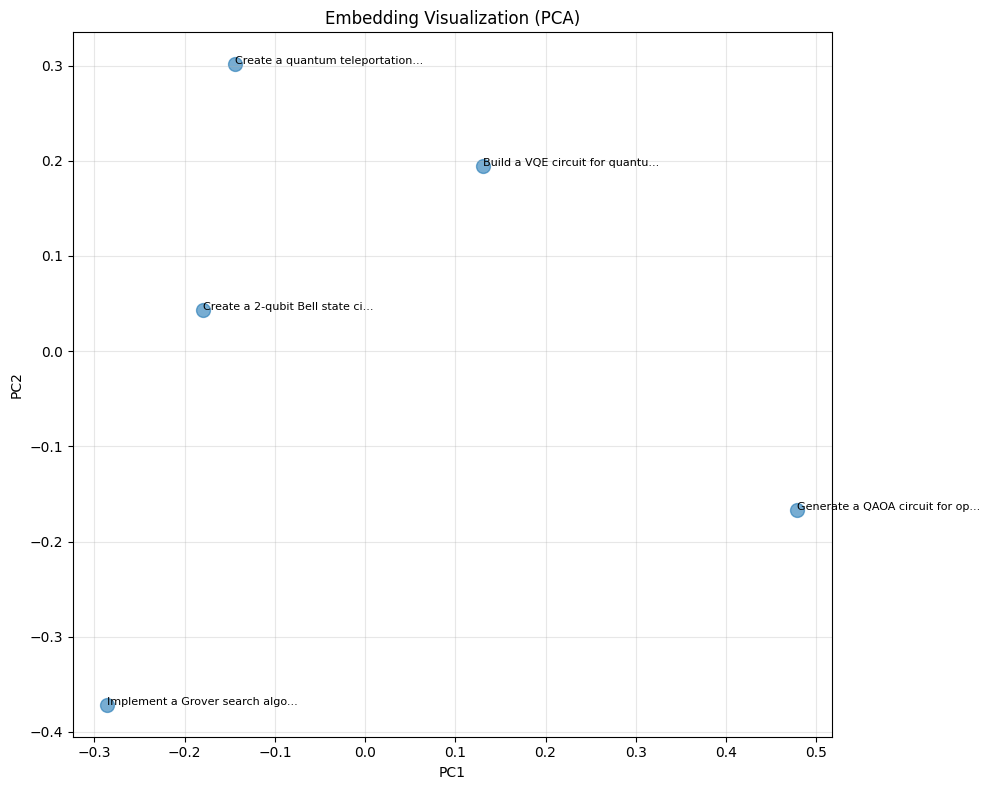

✅ Visualization complete
PCA explained variance: 62.93%


In [6]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.6)

for i, text in enumerate(sample_texts):
    plt.annotate(
        text[:30] + "...",
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        fontsize=8,
    )

plt.title("Embedding Visualization (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Visualization complete")
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")


## 6. Batch Processing

Test batch processing for large-scale embedding generation.


In [7]:
# Generate more sample texts
large_batch = [
    f"Cirq code example {i}: Create a quantum circuit with {i} qubits"
    for i in range(1, 21)
]

# Process in batches
large_embeddings = embedding_model.encode(
    large_batch,
    batch_size=config.get("models.embedding.batch_size", 32),
    show_progress_bar=True,
)

print(f"✅ Processed {len(large_batch)} texts in batches")
print(f"Final embeddings shape: {large_embeddings.shape}")

# Check statistics
stats = embedding_model.get_stats()
print(f"\nEmbedding Statistics:")
print(f"  Total embeddings: {stats['total_embeddings']}")
print(f"  Total batches: {stats['total_batches']}")
print(f"  Total texts: {stats['total_texts']}")


2025-12-02 16:29:46.797 | DEBUG    | src.rag.embeddings:encode:166 - Generating embeddings for 20 texts


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Processed 20 texts in batches
Final embeddings shape: (20, 768)

Embedding Statistics:
  Total embeddings: 26
  Total batches: 3
  Total texts: 26


## 7. Model Information

Display model information and capabilities.


In [8]:
print("Embedding Model Information:")
print("=" * 60)
print(f"Model Name: {embedding_model.model_name}")
print(f"Embedding Dimension: {embedding_model.get_embedding_dimension()}")
print(f"Device: {embedding_model.device}")
print(f"Model Type: {type(embedding_model.model).__name__}")
print("=" * 60)


Embedding Model Information:
Model Name: BAAI/bge-base-en-v1.5
Embedding Dimension: 768
Device: cpu
Model Type: SentenceTransformer
